## Load Data

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load pre-processed timeseries

In [2]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_forcedresponse_ds = xr.open_dataset('%s/CESM1_ForcedResponse_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

Get the variables.

In [6]:
ens_vars = list(cesm1_pic_ds.data_vars)

In [7]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data,testing=False):
    ''' Standardize the data. '''
    
    # if data.std()==0: # edge case that the standard deviation is zero
    if np.isclose(data.std(),0,atol=1e-5): # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    if testing:
        print(data)
        print(data_std)
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [8]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

In [9]:
def calc_tauvar2(autocorr,alpha=0.95):
    '''
    Calculate the autocorrelation time using Leroy (2008), with a selection of significant lags following Phojan.
    Taking sample coefficients at all available lags in estimating Leroy’s uncertainty of the trend will provide zero uncertainty;
    specifically, [the sum of the lagged correlations] is zero. Therefore, it is necessary to set up the criterion to determine which
    sample autocorrelation coefficients to include in the computation. The criterion used in this study is to
    include only the statistically significant [at 95%] coefficients up to 10 log10(T) lags in the summation.
    '''
    
    # the length of the autocorrelation is equal to the length of the timeseries
    N = len(autocorr)
    
    # lags up to "10 log10(T) lags in the summation"
    max_lag = int(10*np.log10(N))
    
    # Select autocorrelation only within a "max lag" of lag-0
    valid_autocorrs = autocorr[N//2-max_lag:N//2+max_lag+1]
    
    # calculate a critical t-statistic
    t_crit = stats.t.ppf((1+alpha)/2,df=N)

    # Calculate the statistical significance bound
    # $$ bound = t_{crit} / \sqrt{N}
    correlation_bound = t_crit / np.sqrt(N)
    
    # check if the autocorrelations are significant
    is_sig_bool = np.abs(valid_autocorrs) > correlation_bound

    # select the significant correlations and sum them to get the correlation time
    tau_var = np.sum(valid_autocorrs[is_sig_bool])
    
    return tau_var

In [10]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate

def calc_tauvar_wrapper(data):
    
    return xr.DataArray(calc_tauvar2(calc_autocorr(data)))

In [11]:
def calc_lag1_by_dur(data,ann_tsel,durations):
    '''Wrapper for calculating correlation times for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_lag1_by_dur_DATASET(data,ann_tsel,durations)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_lag1_by_dur_DATAARRAY(data,ann_tsel,durations)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')

        
def __calc_lag1_by_dur_DATASET(data,ann_tsel,durations):
    
    annavg_lag1_dict  = {}
    monthly_lag1_dict = {}
    
    for _var in data.data_vars:
        print(_var)
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann     = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        lag1_dict = {}
        lag1_monthly_dict = {}
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            # Handle higher dimensional timeseries fluently (i.e. the AIRS sOLR data is indexed by both time and wavenumber (wnum))
            non_time_dims = list(tseries_dur_subset.dims)
            non_time_dims.remove('year') # drop the time dim
            if len(non_time_dims)==0:
                annual_lag1  = calc_lag1_autocorr(tseries_dur_subset)
                monthly_lag1 = tseries_dur_monthly_subset.groupby('time.month').map(calc_lag1_autocorr)
            else:
                annual_data_stacked = tseries_dur_subset.stack(temp_index=non_time_dims)
                annual_lag1 = annual_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_autocorr).unstack()

                # this bullshit roundabout method is the bastard child of this shittastic stackoverflow page: 
                # https://stackoverflow.com/questions/63082479/how-to-replace-the-current-dimension-of-an-xarray-object-with-two-new-ones
                # We want to reshape the wavenumber X time structure into a wavenumber X month X year structure, but xarray doesn't want to go easily

                # Add new year and month coordinates
                tseries_dur_monthly_subset_newcoords = tseries_dur_monthly_subset.assign_coords(
                    {
                        'year' :tseries_dur_monthly_subset['time.year'],
                        'month':tseries_dur_monthly_subset['time.month'],
                    }
                )

                # Destroy all hierarchy in the data by sending to pandas and hard-reseting the indices.
                # Finally, set the indices to our chosen year X month X wavenumber and return to xarray
                tseries_dur_monthly_subset_reorg = tseries_dur_monthly_subset_newcoords.to_dataframe().reset_index().set_index(['year','month','wnum']).to_xarray() 

                non_year_dims = list(tseries_dur_monthly_subset_reorg.dims)
                non_year_dims.remove('year') # drop the time dim

                monthly_data_stacked = tseries_dur_monthly_subset_reorg.stack(temp_index=non_year_dims)
                monthly_data_stacked = monthly_data_stacked[_var] #.to_array()
                monthly_lag1 = monthly_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_wrapper).unstack()
            
            # Add a 'duration' coordinate
            annual_lag1  = annual_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            monthly_lag1 = monthly_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

            annual_lag1.name  = _var
            monthly_lag1.name = _var
            
            lag1_dict[_dur] = annual_lag1 # save slopes in an inner dictionary
            lag1_monthly_dict[_dur] = monthly_lag1
            
        # combine the data along the new 'duration' dimension
        _temp_lag1_da = xr.merge(list(lag1_dict.values()))

        _temp_lag1_monthly_da = xr.merge(list(lag1_monthly_dict.values()))
        
        del lag1_dict,lag1_monthly_dict
        
        annavg_lag1_dict[_var] = _temp_lag1_da
        monthly_lag1_dict[_var] = _temp_lag1_monthly_da

    data_lag1_dur_ds = xr.merge(annavg_lag1_dict.values())
    data_lag1_monthly_dur_ds = xr.merge(monthly_lag1_dict.values())

    del annavg_lag1_dict,monthly_lag1_dict
    return data_lag1_dur_ds,data_lag1_monthly_dur_ds


def __calc_lag1_by_dur_DATAARRAY(data,ann_tsel,durations):
        
    ens_tseries = data
    _var = data.name

    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

    lag1_dict = {}
    lag1_monthly_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        # Handle higher dimensional timeseries fluently (i.e. the AIRS sOLR data is indexed by both time and wavenumber (wnum))
        non_time_dims = list(tseries_dur_subset.dims)
        non_time_dims.remove('year') # drop the time dim
        if len(non_time_dims)==0:
            annual_lag1  = calc_lag1_autocorr(tseries_dur_subset)
            monthly_lag1 = tseries_dur_monthly_subset.groupby('time.month').map(calc_lag1_autocorr)
        else:
            annual_data_stacked = tseries_dur_subset.stack(temp_index=non_time_dims)
            annual_lag1 = annual_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_autocorr).unstack()

            # this bullshit roundabout method is the bastard child of this shittastic stackoverflow page: 
            # https://stackoverflow.com/questions/63082479/how-to-replace-the-current-dimension-of-an-xarray-object-with-two-new-ones
            # We want to reshape the wavenumber X time structure into a wavenumber X month X year structure, but xarray doesn't want to go easily

            # Add new year and month coordinates
            tseries_dur_monthly_subset_newcoords = tseries_dur_monthly_subset.assign_coords(
                {
                    'year' :tseries_dur_monthly_subset['time.year'],
                    'month':tseries_dur_monthly_subset['time.month'],
                }
            )

            # Destroy all hierarchy in the data by sending to pandas and hard-reseting the indices.
            # Finally, set the indices to our chosen year X month X wavenumber and return to xarray
            tseries_dur_monthly_subset_reorg = tseries_dur_monthly_subset_newcoords.to_dataframe().reset_index().set_index(['year','month','wnum']).to_xarray() 

            non_year_dims = list(tseries_dur_monthly_subset_reorg.dims)
            non_year_dims.remove('year') # drop the time dim

            monthly_data_stacked = tseries_dur_monthly_subset_reorg.stack(temp_index=non_year_dims)
            monthly_lag1 = monthly_data_stacked.groupby('temp_index',restore_coord_dims=True).map(calc_lag1_wrapper).unstack()

        # Add a 'duration' coordinate
        annual_lag1  = annual_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        monthly_lag1 = monthly_lag1.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        annual_lag1.name  = _var
        monthly_lag1.name = _var

        lag1_dict[_dur] = annual_lag1 # save slopes in an inner dictionary
        lag1_monthly_dict[_dur] = monthly_lag1

    # combine the data along the new 'duration' dimension
    _temp_lag1_da = xr.merge(list(lag1_dict.values()))

    _temp_lag1_monthly_da = xr.merge(list(lag1_monthly_dict.values()))

    del lag1_dict,lag1_monthly_dict
    return _temp_lag1_da,_temp_tauvar_monthly_da

In [12]:
def calc_stddev_by_dur(data,ann_tsel,durations):
    '''Wrapper for calculating slopes for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_stddev_by_dur_DATASET(data,ann_tsel,durations)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_stddev_by_dur_DATAARRAY(data,ann_tsel,durations)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')

        
def __calc_stddev_by_dur_DATASET(data,ann_tsel,durations):
    
    annavg_stddev_dict  = {}
    monthly_stddev_dict = {}
    
    for _var in data.data_vars:
        print(_var)
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann     = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        stddev_dict = {}
        stddev_monthly_dict = {}
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            annual_stddev  = tseries_dur_subset.std(dim='year')
            monthly_stddev = tseries_dur_monthly_subset.groupby('time.month').std(dim='time')

            # Add a 'duration' coordinate
            annual_stddev  = annual_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            monthly_stddev = monthly_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

            annual_stddev.name  = _var
            monthly_stddev.name = _var
            
            stddev_dict[_dur] = annual_stddev # save slopes in an inner dictionary
            stddev_monthly_dict[_dur] = monthly_stddev
            
        # combine the data along the new 'duration' dimension
        _temp_stddev_da = xr.merge(list(stddev_dict.values()))

        _temp_stddev_monthly_da = xr.merge(list(stddev_monthly_dict.values()))
        
        del stddev_dict,stddev_monthly_dict
        
        annavg_stddev_dict[_var] = _temp_stddev_da
        monthly_stddev_dict[_var] = _temp_stddev_monthly_da

    data_stddev_dur_ds = xr.merge(annavg_stddev_dict.values())
    data_stddev_monthly_dur_ds = xr.merge(monthly_stddev_dict.values())

    del annavg_stddev_dict,monthly_stddev_dict
    return data_stddev_dur_ds,data_stddev_monthly_dur_ds

    # return data.map(__calc_stddev_by_dur_DATAARRAY,ann_tsel=ann_tsel,durations=durations)


def __calc_stddev_by_dur_DATAARRAY(data,ann_tsel,durations):
        
    ens_tseries = data
    _var = data.name

    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

    stddev_dict = {}
    stddev_monthly_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset         = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        annual_stddev  = tseries_dur_subset.std(dim='year')
        monthly_stddev = tseries_dur_monthly_subset.groupby('time.month').std(dim='time')

        # Add a 'duration' coordinate
        annual_stddev  = annual_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        monthly_stddev = monthly_stddev.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        annual_stddev.name  = _var
        monthly_stddev.name = _var

        stddev_dict[_dur] = annual_stddev # save slopes in an inner dictionary
        stddev_monthly_dict[_dur] = monthly_stddev

    # combine the data along the new 'duration' dimension
    _temp_stddev_da = xr.merge(list(stddev_dict.values()))

    _temp_stddev_monthly_da = xr.merge(list(stddev_monthly_dict.values()))

    del stddev_dict,stddev_monthly_dict
    return _temp_stddev_da,_temp_stddev_monthly_da

### Do calculations

### Calculate standard deviation by dur

I need to do this annually and monthly.

In [23]:
min_dur = 5
max_dur = 200

step_dur = 5

pic_durations = np.arange(min_dur,max_dur+1,step_dur)

In [24]:
pic_tsel = slice('0400-01-01','2200-12-31')
olr_vars = ['FLUT','FLUTC']

stddevs_ann,stddevs_monthly = calc_stddev_by_dur(cesm1_pic_ds[olr_vars],ann_tsel=pic_tsel,durations=pic_durations)

FLUT
FLUTC


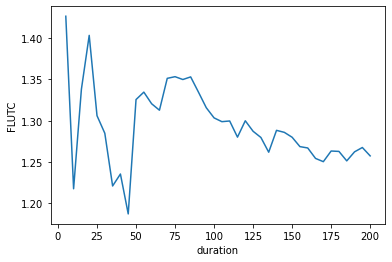

In [25]:
stddevs_ann['FLUTC'].plot()

Maybe 10-15% error, but this is calculated accurately with a pretty short record.

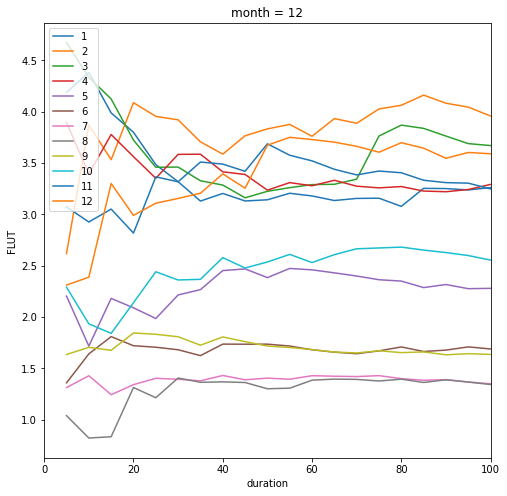

In [26]:
plt.subplots(1,1,figsize=(8,8))

for i,_monthly_data in enumerate(stddevs_monthly['FLUT']):
    # print(_monthly_data)
    
    _monthly_data.plot(label=i+1)
    
plt.xlim(0,100)
plt.legend()

In [63]:
# start_years = ['0400','0600','0800','1000','1200','1400','1600','1800','2000']
# end_years = ['0599','0799','0999','1199','1399','1599','1799','1999','2199']
start_years = ['0400','0800','1200','1600']
end_years = ['0799','1199','1599','1999']

tsels = []

for start_year,end_year in zip(start_years,end_years):
    _start_tsel = '%s-01-01' % start_year
    _end_tsel = '%s-01-01' % end_year
    _tsel = slice(_start_tsel,_end_tsel)
    
    tsels.append(_tsel)
    
min_duration = 10
max_duration = 400
durations = np.arange(min_duration,max_duration+1,2)

In [65]:
olr_vars = ['FLUT','FLUTC']

lag1s_ann     = []
lag1s_monthly = []

for i,_tsel in enumerate(tsels):
    _lag1_ann,_lag1_monthly = calc_lag1_by_dur(cesm1_pic_ds[olr_vars],_tsel,durations=durations)
    
    _lag1_ann = _lag1_ann.assign_coords({'run':i+1}).expand_dims('run',axis=-1)
    _lag1_monthly = _lag1_monthly.assign_coords({'run':i+1}).expand_dims('run',axis=-1)
    
    lag1s_ann.append(_lag1_ann)
    lag1s_monthly.append(_lag1_monthly)
    
    # if i == 2: break

# lag1s_ann_allruns = xr.merge(lag1s_ann)
# lag1s_monthly_allruns = xr.merge(lag1s_monthly)

lag1s_ann_allruns2 = xr.merge(lag1s_ann)
lag1s_monthly_allruns2 = xr.merge(lag1s_monthly)

FLUT
FLUTC
FLUT
FLUTC
FLUT
FLUTC
FLUT
FLUTC


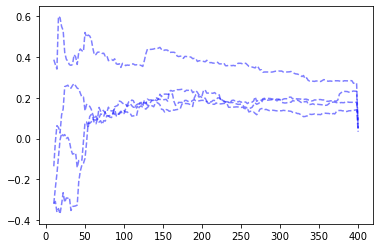

In [66]:
for _run in lag1s_ann_allruns2.run:
    _run_data = lag1s_ann_allruns2['FLUT'].sel(run=_run)
    
    plt.plot(_run_data.duration,_run_data,color='blue',linestyle='dashed',alpha=0.5)

Wow, they take a really long time to converge.

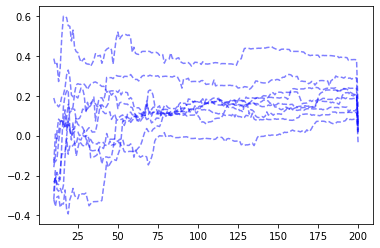

In [56]:
for _run in lag1s_ann_allruns.run:
    _run_data = lag1s_ann_allruns['FLUT'].sel(run=_run)
    
    plt.plot(_run_data.duration,_run_data,color='blue',linestyle='dashed',alpha=0.5)

In [42]:
_lag1_ann.assign_coords({'run':i+1}).expand_dims('run',axis=-1)

<xarray.Dataset>
Dimensions:   (duration: 191)
Coordinates:
  * duration  (duration) int64 10 11 12 13 14 15 16 ... 195 196 197 198 199 200
Data variables:
    FLUT      (duration) float64 -0.3178 -0.2121 -0.2407 ... 0.1846 0.07941
    FLUTC     (duration) float64 -0.2084 -0.06767 -0.108 ... 0.3271 0.1006

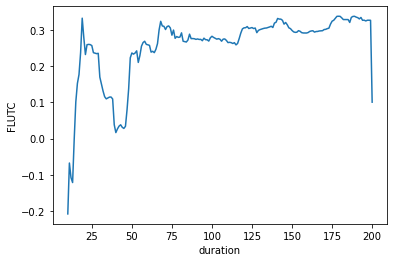

In [40]:
_lag1_ann['FLUTC'].plot()

In [19]:
cesm1_lag1_ann_A,cesm1_lag1_monthly_A = calc_lag1_by_dur(cesm1_pic_ds,slice('0400-01-01','0999-12-31'),durations=durations)

cesm1_lag1_ann_B,cesm1_lag1_monthly_B = calc_lag1_by_dur(cesm1_pic_ds,slice('1000-01-01','1599-12-31'),durations=durations)

cesm1_lag1_ann_C,cesm1_lag1_monthly_C = calc_lag1_by_dur(cesm1_pic_ds,slice('1601-01-01','2199-12-31'),durations=durations)

FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC
FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC
FLUT
FLUTC
TS
ICEFRAC
TMQ
FSNTOA
FSNTOAC
FSNS
FSNSC


This plot is telling me that in the best case scenario, it take ~100 years for us to know the "true" autocorrelation time well.

FLUT FLUT
FLUTC FLUTC
TS TS
ICEFRAC ICEFRAC
TMQ TMQ
FSNTOA FSNTOA
FSNTOAC FSNTOAC
FSNS FSNS
FSNSC FSNSC


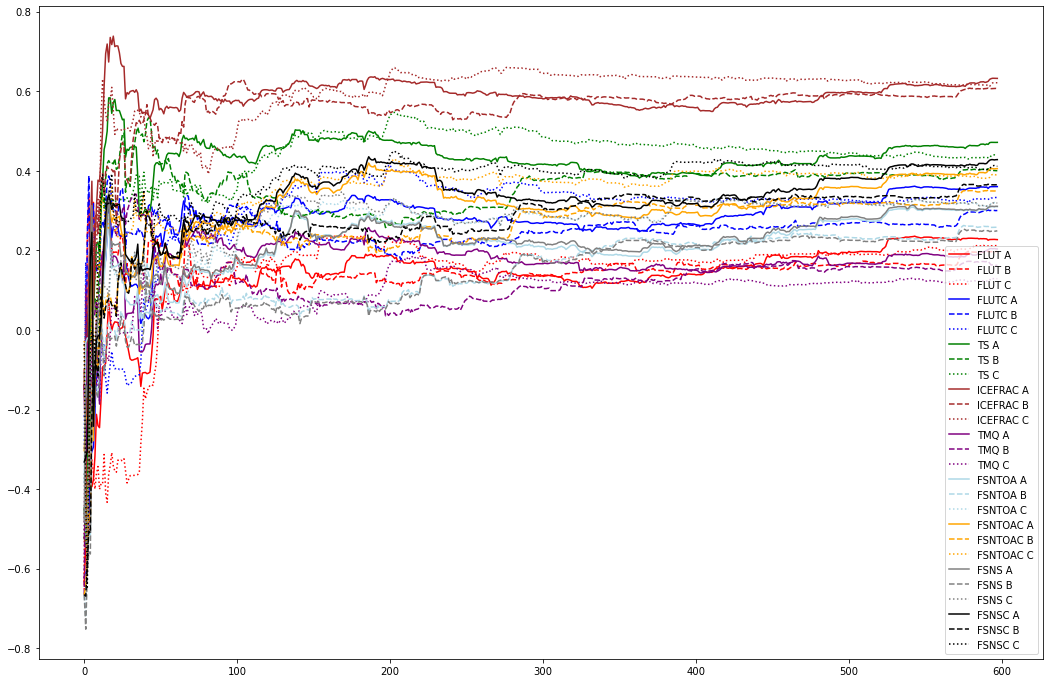

In [59]:
lag1_fig,lag1_ax = plt.subplots(1,1,figsize=(18,12))

colors = ['red','blue','green','brown','purple','lightblue','orange','grey','black']

for _varA,_varB,_varC,_color in zip(cesm1_lag1_ann_A,cesm1_lag1_ann_B,cesm1_lag1_ann_C,colors):
    print(_varA,_varB)
    lag1_ax.plot(cesm1_lag1_ann_A[_varA],label=_varA+' A',c=_color)
    lag1_ax.plot(cesm1_lag1_ann_B[_varB],label=_varB+' B',linestyle='dashed',c=_color)
    lag1_ax.plot(cesm1_lag1_ann_C[_varC],label=_varC+' C',linestyle='dotted',c=_color)
    # break
    
plt.legend()

This plot is telling me that in the best case scenario, it takes a >50 years for us to know the "true" lag-1 autocorrelation well. And even then, there is quite a bit of uncertainty.